In [1]:

from src.components.nn_data_ingestion import FraudDetectionDataset,SequentialFraudDetectionDataset,BaggingSequentialFraudDetectionDataset
from src.baseline.data_ingestion import DataIngestorFactory, DataIngestorConfig
from torch.utils.data import DataLoader
from src.baseline.features_engineering import PreprocessorPipeline
import pandas as pd
import os
import torch
from src.components.lstm_nn import LSTM_NN
from src.components.lstm_attention_nn import LSTM_A_NN
from src.components.lstm_reference_nn import LSTM_REF
from src.components.bagging_lstm_ffnn import HybridLSTM_FFNN

In [2]:

os.chdir(rf"c:\Users\thuhi\workspace\fraud_detection")
print(os.getcwd())

factory = DataIngestorFactory()
ingestor = factory.create_ingestor("duration_pkl")
train_df, validation_df = ingestor.ingest(
    dir_path=rf"C:\Users\thuhi\workspace\fraud_detection\data\transformed_data",
    start_train_date="2018-07-01",
    train_duration=35,
    test_duration=30,
    delay=7
)
pos_weight = 1,5 * 1/torch.tensor(train_df[DataIngestorConfig().output_feature].sum()
                              / (len(train_df) - train_df[DataIngestorConfig().output_feature].sum()))

check_point =rf"C:\Users\thuhi\workspace\fraud_detection\checkpoints\bagging-20250616_170522-run14bs512-ep20-pat5-174.82027257240202-traindur35-testdur7-hidden_size128epoch=03-val_loss=0.93.ckpt"
model = HybridLSTM_FFNN.load_from_checkpoint(
    checkpoint_path=check_point,
    input_size=len(DataIngestorConfig.input_features_transformed),
    hidden_size=100,
    num_layers=1,         # As in reference
    dropout=0.0,          # As in reference
    learning_rate=1e-4 ,
    pos_weight=pos_weight
    
)
validation_preprocessed = PreprocessorPipeline(validation_df,add_method=["scale"]).process()
train_preprocessed = PreprocessorPipeline(train_df,add_method=["scale"]).process()

c:\Users\thuhi\workspace\fraud_detection


In [3]:

validation_data = BaggingSequentialFraudDetectionDataset(validation_preprocessed, seq_len= 7)
train_data = BaggingSequentialFraudDetectionDataset(train_preprocessed,seq_len=7)
batch_size = 512

validation_loader = DataLoader(
    validation_data,
    batch_size=batch_size,
    num_workers=8,
    persistent_workers=True,
    shuffle=False,
    pin_memory= True,
    prefetch_factor=6

)

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    num_workers=8,
    persistent_workers=True,
    shuffle=False,
    pin_memory= True,
    prefetch_factor=6)

In [4]:

# Normalize if needed (replace with your training mean/std)
# mean = torch.tensor(train_mean)
# std = torch.tensor(train_std)
# test_data = (test_data - mean) / std

# Load the model

model.eval()
all_probs = []
all_preds = []

with torch.no_grad():
    for batch in validation_loader:
        # If your dataset returns (X, y), unpack it
        if isinstance(batch, (tuple, list)):
            X = batch[0]
        else:
            X = batch
        X = X.to(model.device)
        y_hat = model(X)
        y_prob = torch.sigmoid(y_hat).squeeze(-1)
        y_pred = (y_prob > 0.5).float()
        all_probs.append(y_prob.cpu())
        all_preds.append(y_pred.cpu())

# Concatenate all predictions
import torch
y_prob = torch.cat(all_probs)
y_pred = torch.cat(all_preds)

print(f"Predicted probabilities shape: {y_prob.shape}")
print(f"Predicted labels shape: {y_pred.shape}")

AttributeError: 'list' object has no attribute 'to'

In [5]:
# Set the model to evaluation mode. This is ESSENTIAL to trigger the multi-output logic.
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to store the separate probabilities
all_final_probs, all_ffnn_probs, all_lstm_probs = [], [], []
all_labels = []

print("Starting inference to capture all three probability streams...")

with torch.no_grad():
    for batch in validation_loader:
        # Unpack the batch from our BaggingSequentialFraudDetectionDataset
        inputs, y = batch
        historical_x, target_x = inputs
        all_labels.append(y)

        # Move data to the correct device
        historical_x = historical_x.to(device)
        target_x = target_x.to(device)
        
        # The model will return a tuple of three logit tensors in eval mode
        final_logits, ffnn_logits, lstm_logits = model((historical_x, target_x))
        
        # Convert all logits to probabilities and store them
        all_final_probs.append(torch.sigmoid(final_logits).squeeze(-1).cpu())
        all_ffnn_probs.append(torch.sigmoid(ffnn_logits).squeeze(-1).cpu())
        all_lstm_probs.append(torch.sigmoid(lstm_logits).squeeze(-1).cpu())

# Concatenate all batch results into single tensors
y_true_final = torch.cat(all_labels).numpy()
y_prob_final = torch.cat(all_final_probs).numpy()
y_prob_ffnn = torch.cat(all_ffnn_probs).numpy()
y_prob_lstm = torch.cat(all_lstm_probs).numpy()

print("\n--- Inference Complete ---")

Starting inference to capture all three probability streams...

--- Inference Complete ---


In [6]:
predicted_proba = pd.DataFrame(y_prob.cpu())
validation_preprocessed.reset_index(drop=True,inplace=True)
validation_preprocessed["prob"] = predicted_proba
validation_preprocessed["TX_FRAUD"].value_counts()


NameError: name 'y_prob' is not defined

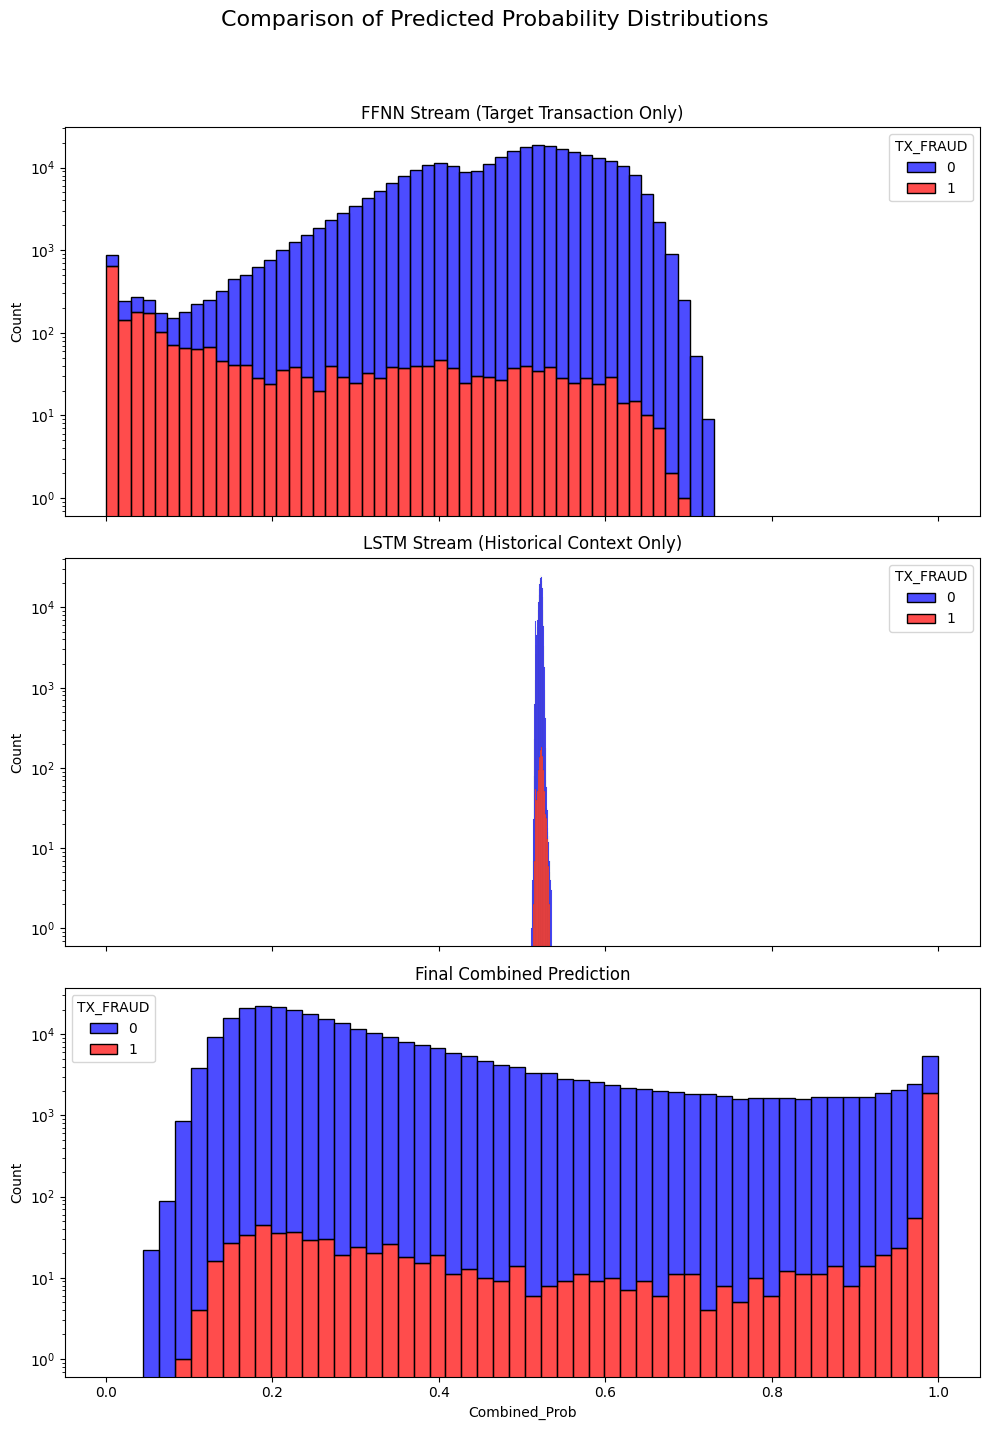

NameError: name 'f1_score' is not defined

: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
results_df = pd.DataFrame({
    'TX_FRAUD': y_true_final,
    'FFNN_Prob': y_prob_ffnn,
    'LSTM_Prob': y_prob_lstm,
    'Combined_Prob': y_prob_final
})

# --- Visualize the Distributions ---
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
fig.suptitle('Comparison of Predicted Probability Distributions', fontsize=16)

# Plot 1: FFNN Stream Only
sns.histplot(data=results_df, x="FFNN_Prob", hue="TX_FRAUD", multiple="stack", bins=50,
             palette={0: "blue", 1: "red"}, alpha=0.7, ax=axes[0])
axes[0].set_title("FFNN Stream (Target Transaction Only)")
axes[0].set_yscale('log') # Use log scale to see the rare fraud cases

# Plot 2: LSTM Stream Only
sns.histplot(data=results_df, x="LSTM_Prob", hue="TX_FRAUD", multiple="stack", bins=50,
             palette={0: "blue", 1: "red"}, alpha=0.7, ax=axes[1])
axes[1].set_title("LSTM Stream (Historical Context Only)")
axes[1].set_yscale('log')

# Plot 3: Final Combined Model
sns.histplot(data=results_df, x="Combined_Prob", hue="TX_FRAUD", multiple="stack", bins=50,
             palette={0: "blue", 1: "red"}, alpha=0.7, ax=axes[2])
axes[2].set_title("Final Combined Prediction")
axes[2].set_yscale('log')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- Print out metrics for the final combined prediction ---
y_true = results_df["TX_FRAUD"]
y_scores = results_df["Combined_Prob"]
y_pred_bin = (y_scores > 0.5).astype(int)

f1 = f1_score(y_true, y_pred_bin)
print(f"\nF1 Score (at 0.5 threshold) for Combined Model: {f1:.4f}")